In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import torch
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules import dropout
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from os import path
from torch.utils.data import Dataset
from torch.utils.data import WeightedRandomSampler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tsai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.9/298.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 53.3 MB/s eta 0:00:00


In [4]:
from tsai.all import *

In [5]:
flag_cuda = torch.cuda.is_available()
torch.manual_seed(42)
np.random.seed(42)
device= None 
if not flag_cuda:
    print('Using CPU')
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print('Using GPU')

Using GPU


# Datasplit generation

In [6]:
PATH = '/content/drive/MyDrive/ECE542/CompetitiveProject/ECE542_sp2022_Project_TerrainRecognition'
PATH = PATH +'/TrainingData/'
TEST_PATH = "./TestData/"
val_subject = 6
# test_subject = 8

In [7]:
files = []
for filename in os.listdir(PATH):
    files.append(filename)
files = sorted(files, key = lambda x: (int(x.split('_')[1]),int(x.split('_')[2]), x.split('_')[4] ))
files_train = list(filter(lambda x: int(x.split('_')[1]) not in  [val_subject], files))
files_test = list(filter(lambda x: int(x.split('_')[1]) == val_subject, files))
# files_test = list(filter(lambda x: int(x.split('_')[1])== test_subject, files))

In [8]:
files_test

['subject_006_01__x_time.csv',
 'subject_006_01__x.csv',
 'subject_006_01__y_time.csv',
 'subject_006_01__y.csv',
 'subject_006_02__x_time.csv',
 'subject_006_02__x.csv',
 'subject_006_02__y_time.csv',
 'subject_006_02__y.csv',
 'subject_006_03__x_time.csv',
 'subject_006_03__x.csv',
 'subject_006_03__y_time.csv',
 'subject_006_03__y.csv']

In [9]:
files_train_y = files_train[3::4]
# files_train_y

In [10]:
files_y_val = pd.concat([pd.read_csv(PATH + i , header=None) for i in files_train_y])

In [11]:
continue_loop = True
threshold = 0.005
_, files_split_dist = np.unique(files_y_val, return_counts=True)
files_split_dist = np.divide(files_split_dist, np.max(files_split_dist))
while continue_loop:
  files_train_y_split_1 = random.sample(files_train_y, int(len(files_train_y) * 0.8))
  files_train_y_split_2 = [i for i in files_train_y if i not in files_train_y_split_1]
  files_split_1_val = pd.concat([pd.read_csv(PATH + i , header=None) for i in files_train_y_split_1])
  files_split_2_val = pd.concat([pd.read_csv(PATH + i , header=None) for i in files_train_y_split_2])
  _, files_split_1_dist = np.unique(files_split_1_val, return_counts=True)
  files_split_1_dist = np.divide(files_split_1_dist, np.max(files_split_1_dist))
  _, files_split_2_dist = np.unique(files_split_2_val, return_counts=True)
  files_split_2_dist = np.divide(files_split_2_dist, np.max(files_split_2_dist))
  if ((files_split_dist[0] - threshold <= files_split_1_dist[0] <= files_split_dist[0] + threshold) and
      (files_split_dist[1] - threshold <= files_split_1_dist[1] <= files_split_dist[1] + threshold) and
      (files_split_dist[2] - threshold <= files_split_1_dist[2] <= files_split_dist[2] + threshold) and
      (files_split_dist[3] - threshold <= files_split_1_dist[3] <= files_split_dist[3] + threshold) and
      (files_split_dist[0] - threshold <= files_split_2_dist[0] <= files_split_dist[0] + threshold) and
      (files_split_dist[1] - threshold <= files_split_2_dist[1] <= files_split_dist[1] + threshold) and
      (files_split_dist[2] - threshold <= files_split_2_dist[2] <= files_split_dist[2] + threshold) and
      (files_split_dist[3] - threshold <= files_split_2_dist[3] <= files_split_dist[3] + threshold)):
          print(files_split_1_dist, files_split_2_dist, files_split_dist)
          break


[1.         0.05495725 0.07422376 0.21287912] [1.         0.05807915 0.07645746 0.20770244] [1.         0.05572816 0.07477534 0.21160081]


In [12]:
files_train_y_split_1_names = ["_".join(i.split("__")[: -1]) for i in files_train_y_split_1]
files_train_y_split_2_names = ["_".join(i.split("__")[: -1]) for i in files_train_y_split_2]

In [13]:
training_files = [i for i in files_train if "_".join(i.split("__")[: -1]) in files_train_y_split_1_names]
validation_files = [i for i in files_train if "_".join(i.split("__")[: -1]) in files_train_y_split_2_names]

In [14]:
training_files

['subject_001_01__x_time.csv',
 'subject_001_01__x.csv',
 'subject_001_01__y_time.csv',
 'subject_001_01__y.csv',
 'subject_001_02__x_time.csv',
 'subject_001_02__x.csv',
 'subject_001_02__y_time.csv',
 'subject_001_02__y.csv',
 'subject_001_03__x_time.csv',
 'subject_001_03__x.csv',
 'subject_001_03__y_time.csv',
 'subject_001_03__y.csv',
 'subject_001_04__x_time.csv',
 'subject_001_04__x.csv',
 'subject_001_04__y_time.csv',
 'subject_001_04__y.csv',
 'subject_001_06__x_time.csv',
 'subject_001_06__x.csv',
 'subject_001_06__y_time.csv',
 'subject_001_06__y.csv',
 'subject_001_07__x_time.csv',
 'subject_001_07__x.csv',
 'subject_001_07__y_time.csv',
 'subject_001_07__y.csv',
 'subject_001_08__x_time.csv',
 'subject_001_08__x.csv',
 'subject_001_08__y_time.csv',
 'subject_001_08__y.csv',
 'subject_002_01__x_time.csv',
 'subject_002_01__x.csv',
 'subject_002_01__y_time.csv',
 'subject_002_01__y.csv',
 'subject_002_03__x_time.csv',
 'subject_002_03__x.csv',
 'subject_002_03__y_time.csv',


# Dataset generation and training

In [15]:
def windows(d, w, t):
  r = np.arange(len(d))
  s = r[::t]
  z = list(zip(s, s + w))
  f = '{0[0]}:{0[1]}'.format
  g = lambda t: d.iloc[t[0]:t[1]]
  ranges = list(map(f,z))
  return ranges, pd.concat(map(g, z), keys=map(f, z))

In [16]:
def make_dataset(files, X, Y, freq_down=True, flag = False):

    overlap = 30
    if flag:
        overlap = 60
    total_length = 0
    for i in range(0, len(files), 4):
        x_time, x, y_time, y = files[i: i + 4]
        train_df = None
        if freq_down:
            #X_features
            x_time_df = pd.read_csv(PATH + x_time , header=None)
            x_df = pd.read_csv(PATH + x , header=None)
            x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
            x_combined = x_combined.loc[range(1,len(x_combined), 4)].reset_index()  # down sampled the frequency

            #Y_labels
            y_time_df = pd.read_csv(PATH + y_time , header=None)
            y_df = pd.read_csv(PATH + y , header=None)
            y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)

            train_df = pd.concat([x_combined, y_combined], axis=1, ignore_index=True)
            train_df = train_df.drop(columns=[0, 1, 8])  # Dropping the time stamp
            total_length += train_df.shape[0]
            ranges, windows_df = windows(train_df, 60, overlap)
            for ran in ranges:
                l,r = ran.split(':')
                df_range = windows_df.iloc[int(l): int(r)]
                if int(r) > len(windows_df):
                    break
                y_values = df_range[9].values
                x_values = df_range.drop(columns=[9]).values
                X.append(x_values)
                Y.append(Counter(list(y_values)).most_common(1)[0][0])
        else:
            #X_features
            x_time_df = pd.read_csv(PATH + x_time, header=None)
            x_time_df.astype('float64')
            x_df = pd.read_csv(PATH + x, header=None)
            x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
            x_combined = x_combined.rename({0:'timestamp'}, axis='columns')
            x_combined.set_index('timestamp', inplace=True)

            #Y_labels
            y_time_df = pd.read_csv(PATH + y_time , header=None)
            y_time_df.astype('float64')
            y_df = pd.read_csv(PATH + y, header=None)
            y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)
            y_combined = y_combined.rename({0:'timestamp'}, axis='columns')
            y_combined.set_index('timestamp', inplace=True)
            train_df = pd.merge_asof(left=x_combined, right=y_combined, left_index=True, right_index = True, direction='nearest')  # Merging using the nearest values
            total_length += train_df.shape[0]
            ranges, windows_df = windows(train_df, 60, overlap)
            for ran in ranges:
                l,r = ran.split(':')
                df_range = windows_df.iloc[int(l): int(r)]
                if int(r) > len(windows_df):
                    break
                y_values = df_range['1_y'].values
                x_values = df_range.drop(columns=['1_y']).values
                X.append(x_values)
                Y.append(Counter(list(y_values)).most_common(1)[0][0])
    print(total_length, len(X), len(y))
    return X, Y

freq_down boolean flag can be used to flip between 10hz and 40 hz frequency

In [17]:
# train_X, train_y = [], []
# valid_X, valid_y = [], []
# test_X, test_y = [], []

# make_dataset(files_train, train_X, train_y, freq_down=False, flag=True)
# train_X, train_y = np.array(train_X, dtype="float32"), np.array(train_y,dtype="float32")
# make_dataset(files_val, valid_X, valid_y, freq_down=False, flag=True)
# valid_X, valid_y = np.array(valid_X, dtype="float32"),np.array(valid_y, dtype="float32")
# # make_dataset(files_train, test_X, test_y, freq_down=True, flag=True)
# # test_X, test_y = np.array(test_X, dtype="float32"), np.array(test_y, dtype="float32")
# print("Done splitting the data")

In [18]:
train_X, train_y = [], []
valid_X, valid_y = [], []
test_X, test_y = [], []

make_dataset(training_files, train_X, train_y, freq_down=False, flag=True)
train_X, train_y = np.array(train_X, dtype="float32"), np.array(train_y,dtype="float32")
make_dataset(validation_files, valid_X, valid_y, freq_down=False, flag=True)
valid_X, valid_y = np.array(valid_X, dtype="float32"),np.array(valid_y, dtype="float32")
make_dataset(files_test, test_X, test_y, freq_down=False, flag=True)
test_X, test_y = np.array(test_X, dtype="float32"), np.array(test_y, dtype="float32")
print("Done splitting the data")

895233 14911 21
293597 4891 21
152816 2546 21
Done splitting the data


In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [20]:
train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
valid_X = scaler.transform(valid_X.reshape(-1, valid_X.shape[-1])).reshape(valid_X.shape)
test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)

In [21]:
train_X = np.array(train_X)
print(train_X.shape)

(14911, 60, 6)


In [22]:
len(train_y)

14911

In [23]:
test_X.shape, valid_X.shape, test_y.shape, valid_y.shape

((2546, 60, 6), (4891, 60, 6), (2546,), (4891,))

In [24]:
weight  = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_y), y = np.array(train_y))
sample_weights = [round(weight[int(i)],2) for i in train_y]
weight = torch.tensor(weight)
weight = weight.cuda()

In [25]:
np.unique(train_y), weight

(array([0., 1., 2., 3.], dtype=float32),
 tensor([0.3362, 6.0614, 4.4697, 1.5709], device='cuda:0', dtype=torch.float64))

In [26]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv1d(6,16,3)
    self.conv2 = nn.Conv1d(16,32,3)
    self.pool1 = nn.MaxPool1d(2,2)
    self.conv3 = nn.Conv1d(32,64,3)
    self.conv4 = nn.Conv1d(64,128,3)
    self.pool2 = nn.MaxPool1d(2,2)
    self.fc1 = nn.Linear(512, 120)
    self.fc2 = nn.Linear(120, 64)
    self.fc3 = nn.Linear(64,4)
    self.dropout1 = nn.Dropout(0.1)

  def forward(self, x):
    x = F.relu(self.conv1(x.permute(0,2,1)))
    x = self.pool1(F.relu(self.dropout1(self.conv2(x))))
    x = F.relu(self.conv3(x))
    x = self.pool2(F.relu(self.dropout1(self.conv4(x))))
    # print("1",x.shape)
    # x = x.view(-1,3456)
    x = torch.flatten(x,1)
    # print("2",x.shape)
    x = F.relu(self.dropout1(self.fc1(x)))
    x = F.relu(self.dropout1(self.fc2(x)))
    # print("3", x.shape)
    x = self.fc3(x)
    return x

model = Net()
if flag_cuda:
  model.cuda()

In [45]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    self.conv1 = nn.Conv1d(6,16,3)
    self.conv2 = nn.Conv1d(16,32,3)
    self.pool1 = nn.AvgPool1d(2,2)
    self.conv3 = nn.Conv1d(32,64,3)
    self.conv4 = nn.Conv1d(64,128,3)
    self.pool2 = nn.MaxPool1d(2,2)
    self.fc1 = nn.Linear(1536, 120)
    self.fc2 = nn.Linear(120, 64)
    self.fc3 = nn.Linear(64,4)
    self.dropout1 = nn.Dropout(0.1)
    self.dropout2 = nn.Dropout(0.25)
    # self.batch_norm = nn.BatchNorm1d()

  def forward(self, x):
    x = F.relu(self.conv1(x.permute(0,2,1)))
    x = self.pool1(self.dropout2(F.relu(self.conv2(x))))
    # print("1",x.shape)
    x = F.relu(self.conv3(x))
    x = self.pool2(self.dropout1(F.relu(self.conv4(x))))
    x = torch.flatten(x,1)
    # print("2",x.shape)
    x = self.dropout1(F.relu(self.fc1(x)))
    # print("3", x.shape)
    x = self.dropout1(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

model = Net2()
if flag_cuda:
  model.cuda()

In [27]:
class BiLSTM(nn.Module):
  def __init__(self):
    super(BiLSTM, self).__init__()
    self.lstm1 = nn.LSTM(6,60,2,batch_first=True, bidirectional=True)
    self.lstm2 =  nn.LSTM(120,60,2,batch_first=True,bidirectional=True)
    self.lstm3 =  nn.LSTM(120,60,2,batch_first=True,bidirectional=True)
    self.fc1 = nn.Linear(7200, 120)
    self.fc2 = nn.Linear(120, 64)
    self.fc3 = nn.Linear(64,4)
    self.dropout1 = nn.Dropout(0.1)
    self.dropout2 = nn.Dropout(0.25)
    self.dropout3 = nn.Dropout(0.2)
    self.batch_norm = nn.BatchNorm1d(120)


  def forward(self, x):
    x, self.hidden1 = self.lstm1(x)
    x = self.dropout3(self.batch_norm(F.relu(x).permute(0, 2, 1)))
    x = self.dropout1(self.batch_norm(F.relu(self.lstm2(x.permute(0, 2, 1))[0]).permute(0,2,1)))
    # print("1", x.shape)
    x = self.dropout3(F.relu(self.lstm3(x.permute(0, 2, 1))[0]))
    # print("3", x.shape)
    x = torch.flatten(x,1)
    x = self.dropout1(F.relu(self.fc1(x)))
    # print("3", x.shape)
    x = self.dropout1(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

model = BiLSTM()
if flag_cuda:
  model.cuda()


In [ ]:
class ConvLSTM(nn.Module):
  def __init__(self):
    super(ConvLSTM, self).__init__()
    self.conv1 = nn.Conv1d(6,16,3)
    self.lstm1 = nn.LSTM(16,60,2,batch_first=True, bidirectional=True)
    self.lstm2 =  nn.LSTM(120,60,2,batch_first=True,bidirectional=True)
    self.lstm3 =  nn.LSTM(120,60,2,batch_first=True,bidirectional=True)
    self.fc1 = nn.Linear(7200, 120)
    self.fc2 = nn.Linear(120, 64)
    self.fc3 = nn.Linear(64,4)
    self.dropout1 = nn.Dropout(0.1)
    self.dropout2 = nn.Dropout(0.25)
    self.dropout3 = nn.Dropout(0.2)
    self.batch_norm = nn.BatchNorm1d(120)


  def forward(self, x):
    x, self.hidden1 = self.lstm1(x)
    x = self.dropout3(self.batch_norm(F.relu(x).permute(0, 2, 1)))
    x = self.dropout1(self.batch_norm(F.relu(self.lstm2(x.permute(0, 2, 1))[0]).permute(0,2,1)))
    # print("1", x.shape)
    x = self.dropout3(F.relu(self.lstm3(x.permute(0, 2, 1))[0]))
    # print("3", x.shape)
    x = torch.flatten(x,1)
    x = self.dropout1(F.relu(self.fc1(x)))
    # print("3", x.shape)
    x = self.dropout1(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

model = BiLSTM()
if flag_cuda:
  model.cuda()

In [28]:
# Specifying the loss function
criterion = nn.CrossEntropyLoss(weight = weight.float())

# Specify optimizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

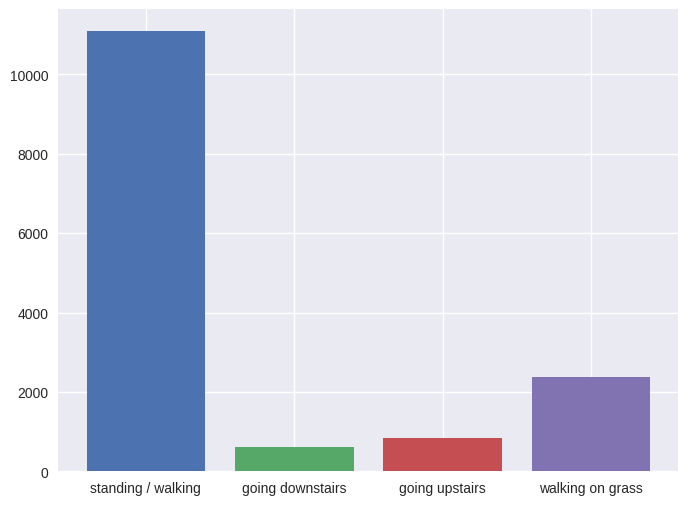

In [29]:
plt.style.use('seaborn')
plt.figure(figsize=(8,6),dpi=100)
text = ["standing / walking", "going downstairs","going upstairs", "walking on grass"]
labels = list(dict(Counter(train_y)).values())
for bar in range(0,4):
    plt.bar(text[bar],labels[bar])

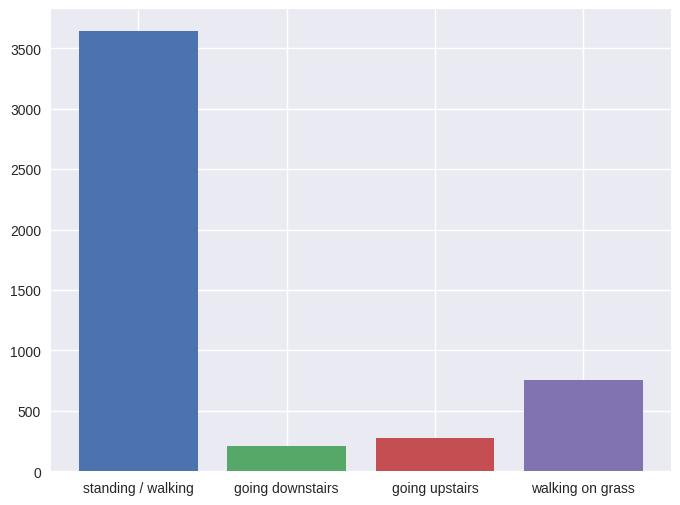

In [30]:
plt.figure(figsize=(8,6),dpi=100)
plt.style.use('seaborn')
text = ["standing / walking", "going downstairs","going upstairs", "walking on grass"]
labels = list(dict(Counter(valid_y)).values())
for bar in range(0,4):
    plt.bar(text[bar],labels[bar])

In [31]:
# weighted_sampler = WeightedRandomSampler(
#     weights=sample_weights,
#     num_samples=len(sample_weights),
#     replacement=True
# )

In [32]:
class TerrainDataset(Dataset):
  def __init__(self, data, target):
    self.data = np.array(data)
    self.target = np.array(target)
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    return self.data[index], self.target[index]


In [33]:
batch_size = 120
train_dataset = TerrainDataset(train_X, train_y)
# x_train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size, sampler=weighted_sampler, shuffle=False)
x_train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size, shuffle=True)
# y_train_loader = torch.utils.data.DataLoader(train_y,batch_size = batch_size, sampler=weighted_sampler)
validation_dataset = TerrainDataset(valid_X, valid_y)
x_validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=False)
# y_validation_loader = torch.utils.data.DataLoader(valid_y, batch_size = batch_size)

test_dataset = TerrainDataset(test_X, test_y)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)
# y_test_loader = torch.utils.data.DataLoader(test_y, batch_size = batch_size)

In [34]:
for data, target in x_train_loader:
  print(list(map(int, list(target))))
  break

[3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 3, 0, 3, 0, 0, 0, 0, 3, 2, 3, 0, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 2, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Epoch: 1 	Training Loss: 0.557020 	Validation Loss: 0.505693
Validation loss decreased (inf --> 0.505693).  Saving model ...
Epoch: 2 	Training Loss: 0.307054 	Validation Loss: 0.724055
Epoch: 3 	Training Loss: 0.246695 	Validation Loss: 0.444888
Validation loss decreased (0.505693 --> 0.444888).  Saving model ...
Epoch: 4 	Training Loss: 0.211787 	Validation Loss: 0.467772
Epoch: 5 	Training Loss: 0.194324 	Validation Loss: 1.768306
Epoch: 6 	Training Loss: 0.176598 	Validation Loss: 1.014886
Epoch: 7 	Training Loss: 0.154439 	Validation Loss: 0.436082
Validation loss decreased (0.444888 --> 0.436082).  Saving model ...
Epoch: 8 	Training Loss: 0.163887 	Validation Loss: 1.223140
Epoch: 9 	Training Loss: 0.178463 	Validation Loss: 0.498933
Epoch: 10 	Training Loss: 0.165936 	Validation Loss: 0.978132
Epoch: 11 	Training Loss: 0.146686 	Validation Loss: 0.591935
Epoch: 12 	Training Loss: 0.123304 	Validation Loss: 0.452002
Epoch: 13 	Training Loss: 0.116369 	Validation Loss: 0.337465
V

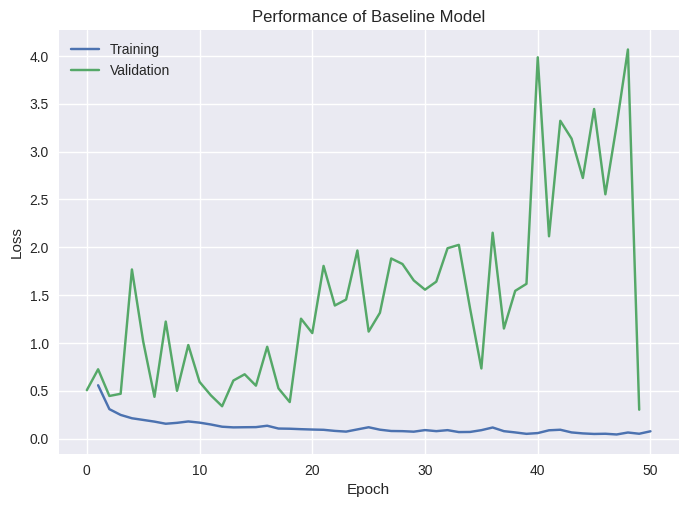

In [35]:
import matplotlib.pyplot as plt

n_epochs = 50 #25

def trainNet(model,criterion,optimizer,n_epochs,flag_cuda):

  train_losslist = []
  valid_losslist = []
  valid_loss_min = np.Inf # track change in validation loss
  for epoch in range(1, n_epochs + 1):
      # Keeping track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
    
      model.train()

      for data,target in x_train_loader:
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          optimizer.zero_grad()
          output = model(data)
          target = target.type(torch.LongTensor) 
          if flag_cuda:
            output, target = output.cuda(), target.cuda()
          loss = criterion(output, target)

          # Backward pass: compute gradient of loss with respect to parameters
          loss.backward()
          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item()*data.size(0)
          
      model.eval()

      for data,target in x_validation_loader:
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          output = model(data)
          target = target.type(torch.LongTensor) 

          if flag_cuda:
            output, target = output.cuda(), target.cuda()

          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
      
      # Calculating average losses
      train_loss = train_loss/len(train_X)
      valid_loss = valid_loss/len(valid_X)
      train_losslist.append(train_loss)
      valid_losslist.append(valid_loss)
          
      #Printing training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      # Saving model if validation loss has decreased
      if valid_loss < valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss
        
  return train_losslist, valid_losslist

# Executing the training
train_losslist, valid_losslist = trainNet(model,criterion,optimizer,n_epochs,flag_cuda)

# Loading the best model
model.load_state_dict(torch.load('model.pt'))

# Plotting the learning curves
plt.plot(range(1, n_epochs + 1), train_losslist, valid_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training','Validation'])
plt.title("Performance of Baseline Model")
plt.show()

In [36]:
classes = [0.,1.,2.,3.]
y_prediction = []

def assessNet(model,criterion, x_test_loader):
  # Tracking test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(4))
  class_total = list(0. for i in range(4))

  # Setting model to evaluate
  model.eval()

  # Iterating over batches of test data

  print(valid_X.shape)

  for data,target in x_test_loader:
      # Obtaining predictions and loss
      if flag_cuda:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      # output = torch.argmax(output,dim = 1)
      target = target.type(torch.LongTensor) 
      if flag_cuda:
        output, target = output.cuda(), target.cuda()
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)
      _, pred = torch.max(output, 1)    
      # Comparing predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      # print(pred)
      y_prediction.extend(pred.cpu().numpy())
      correct = np.squeeze(correct_tensor.numpy()) if not flag_cuda else np.squeeze(correct_tensor.cpu().numpy())
      # Calculating test accuracy for each object class
      for i in range(len(output)):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # Computing the average test loss
  test_loss = test_loss/len(valid_X)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  # Computing the class accuracies
  for i in range(4):
      if class_total[i] > 0:
          print('Test Accuracy of %10s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %10s: N/A (no training examples)' % (classes[i]))

  # Computing the overall accuracy
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))


  return

# assessNet(model,criterion, x_validation_loader)
assessNet(model,criterion, test_dataloader)

(4891, 60, 6)
Test Loss: 0.307499

Test Accuracy of        0.0: 93% (1882/2021)
Test Accuracy of        1.0: 76% (75/98)
Test Accuracy of        2.0: 97% (110/113)
Test Accuracy of        3.0: 71% (224/314)

Test Accuracy (Overall): 89% (2291/2546)


In [37]:
print(classification_report(y_true=test_y, y_pred=y_prediction))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      2021
         1.0       0.96      0.77      0.85        98
         2.0       0.68      0.97      0.80       113
         3.0       0.69      0.71      0.70       314

    accuracy                           0.90      2546
   macro avg       0.82      0.85      0.82      2546
weighted avg       0.91      0.90      0.90      2546



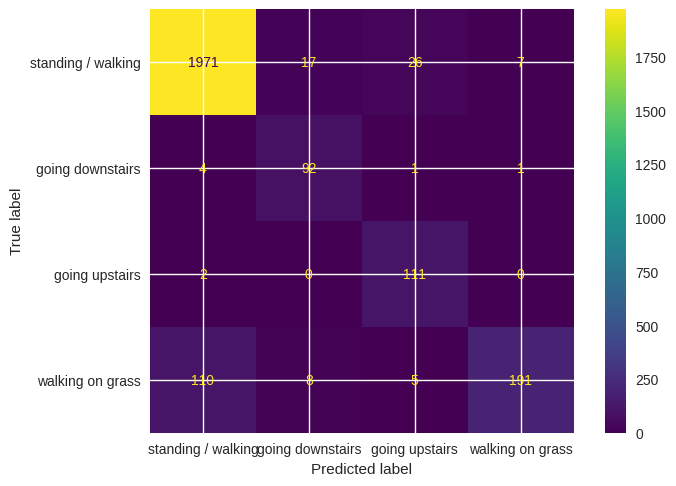

In [145]:
cm = confusion_matrix(y_true=test_y, y_pred=y_prediction)
cmd = ConfusionMatrixDisplay(cm, display_labels=["standing / walking", "going downstairs","going upstairs", "walking on grass"])
cmd.plot()

[Text(0, 0.5, 'standing / walking'),
 Text(0, 1.5, 'going downstairs'),
 Text(0, 2.5, 'going upstairs'),
 Text(0, 3.5, 'walking on grass')]

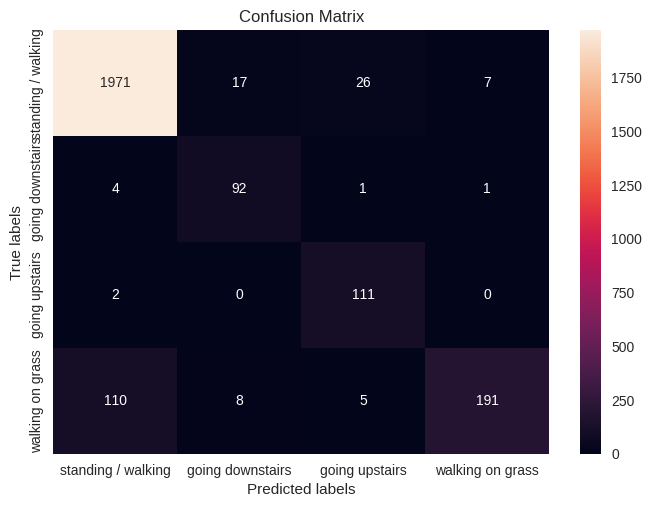

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(["standing / walking", "going downstairs","going upstairs", "walking on grass"]) 
ax.yaxis.set_ticklabels(["standing / walking", "going downstairs","going upstairs", "walking on grass"])

# Sensor data subject wise analysis

In [18]:
import copy

In [19]:
subject_stats = {'mean': [], 'min':[], 'max':[]}
actual_stats = {}

for i in range(6):  # 6 columns stats for all the subjects
  actual_stats[i] = copy.deepcopy(subject_stats)

for key, value in subject_files.items():
  local_files = value
  y_labels = []
  train_df = None
  for i in range(0, len(local_files), 4):
          x_time, x, y_time, y = local_files[i: i + 4]
          train_df = None
        
          #X_features
          x_time_df = pd.read_csv(PATH + x_time, header=None)
          x_time_df.astype('float64')
          x_df = pd.read_csv(PATH + x, header=None)
          x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
          x_combined = x_combined.rename({0:'timestamp'}, axis='columns')
          x_combined.set_index('timestamp', inplace=True)

          #Y_labels
          y_time_df = pd.read_csv(PATH + y_time , header=None)
          y_time_df.astype('float64')
          y_df = pd.read_csv(PATH + y, header=None)
          y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)
          y_combined = y_combined.rename({0:'timestamp'}, axis='columns')
          y_combined.set_index('timestamp', inplace=True)
          train_df = pd.merge_asof(left=x_combined, right=y_combined, left_index=True, right_index = True, direction='nearest')  # Merging using the nearest values
          y_labels.extend(train_df['1_y'].values)
          train_df = train_df.drop(columns=['1_y'])
  
  for index, col in enumerate(train_df.columns[:6]):
    # print(train_df[col].mean())
    actual_stats[index]['mean'].append(train_df[col].mean())
    actual_stats[index]['min'].append(train_df[col].min())
    actual_stats[index]['max'].append(train_df[col].max())

  '''
  print(f"Subject {key} \n", train_df.columns[:6])     # Uncomment to plot the Class distribution for each subject
  print(key, len(y_labels))
  plt.style.use('seaborn')
  plt.figure(figsize=(8,6),dpi=100)
  plt.title(f"Subject {key} class distribution")
  text = ["standing / walking", "going downstairs","going upstairs", "walking on grass"]
  labels = list(dict(Counter(y_labels)).values())
  for bar in range(0,4):
      plt.bar(text[bar],labels[bar])
  '''

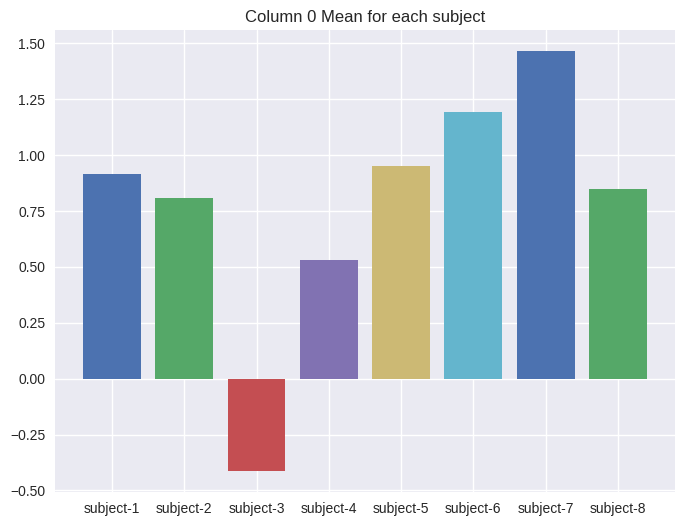

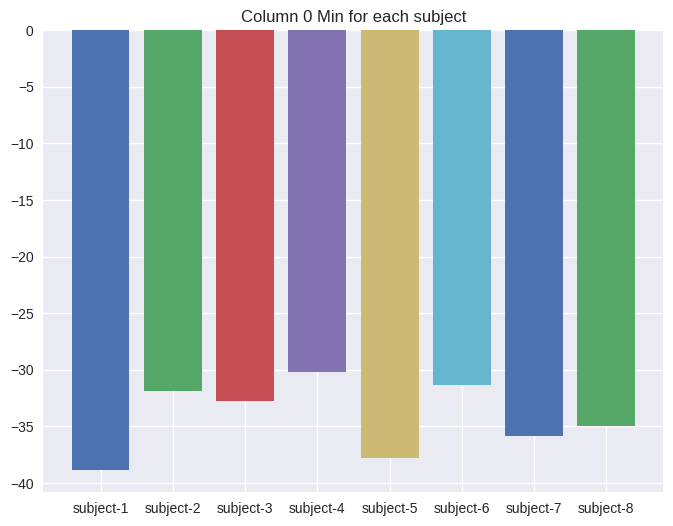

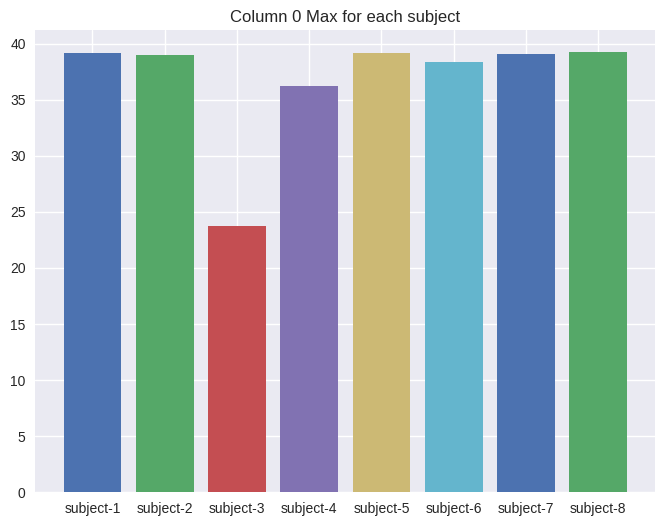

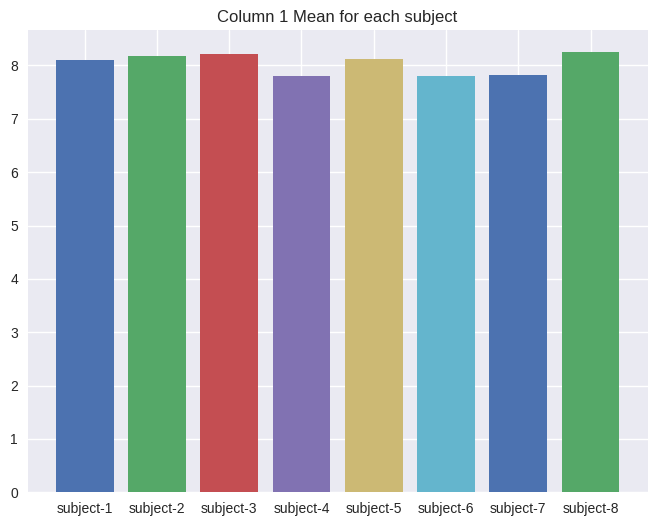

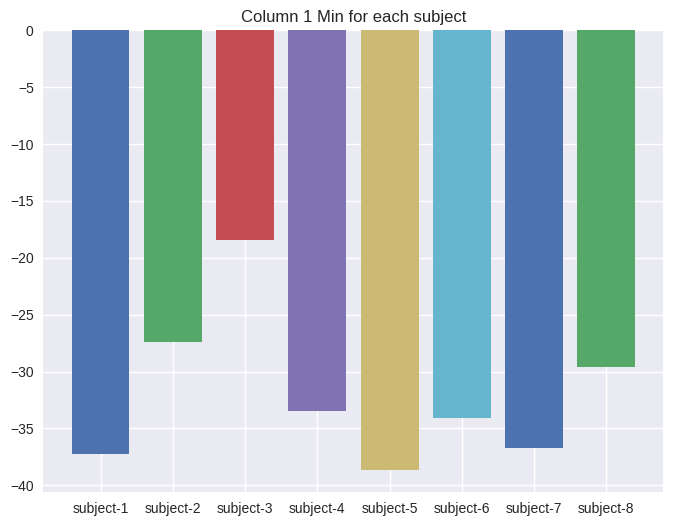

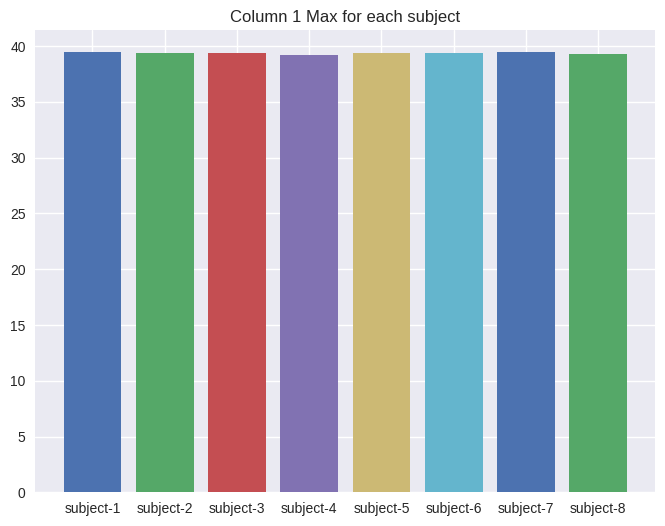

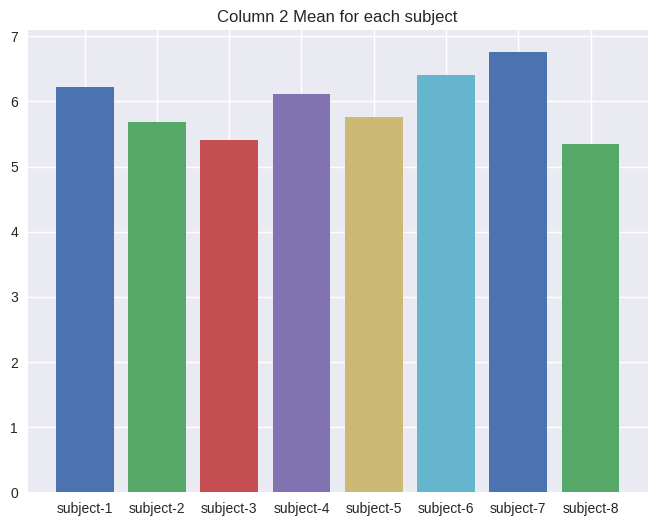

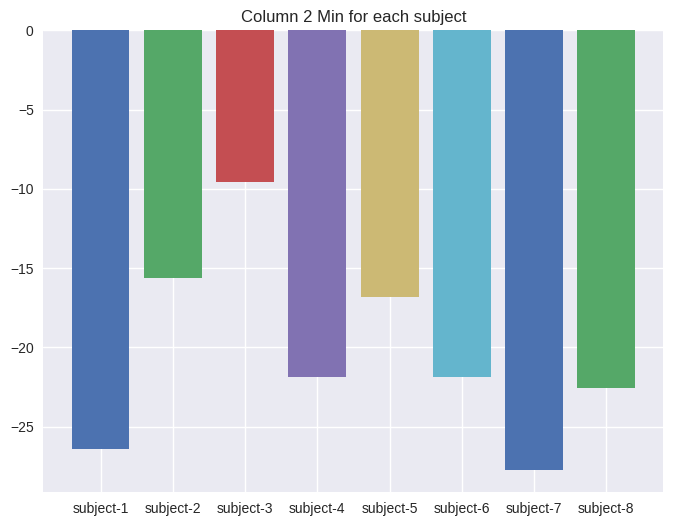

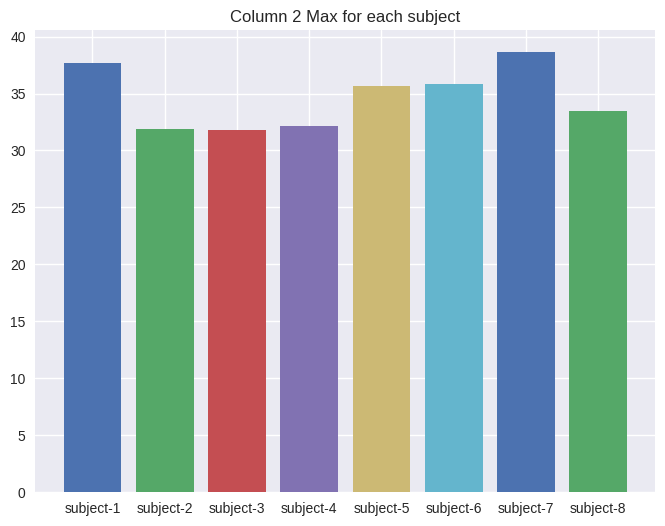

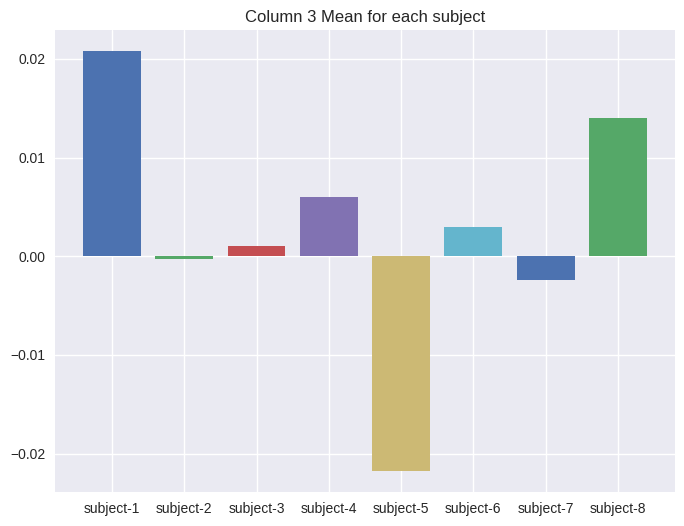

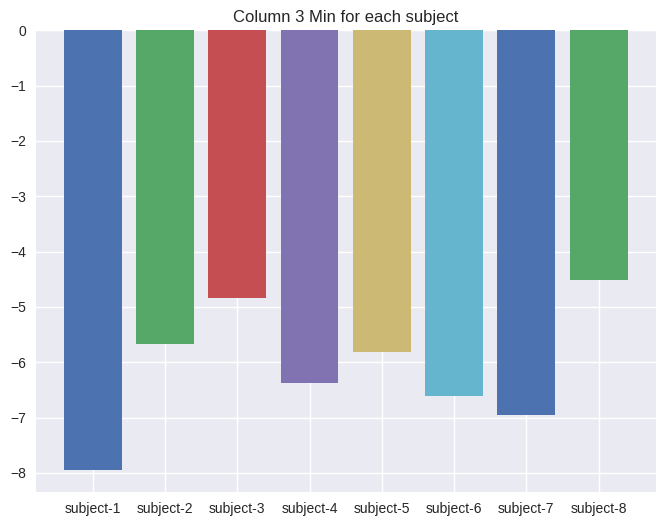

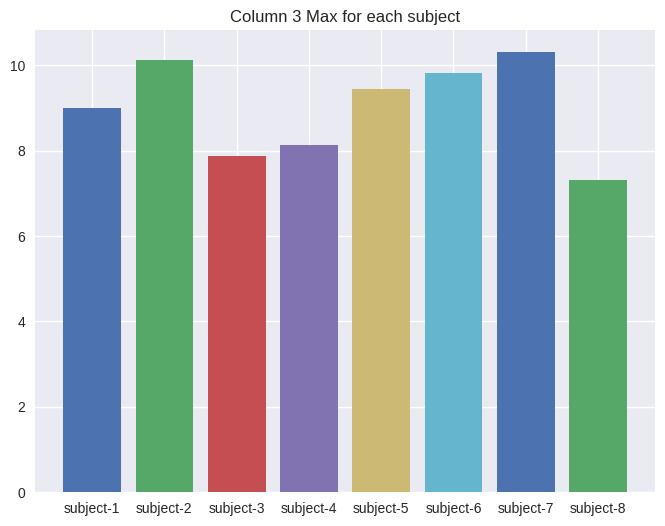

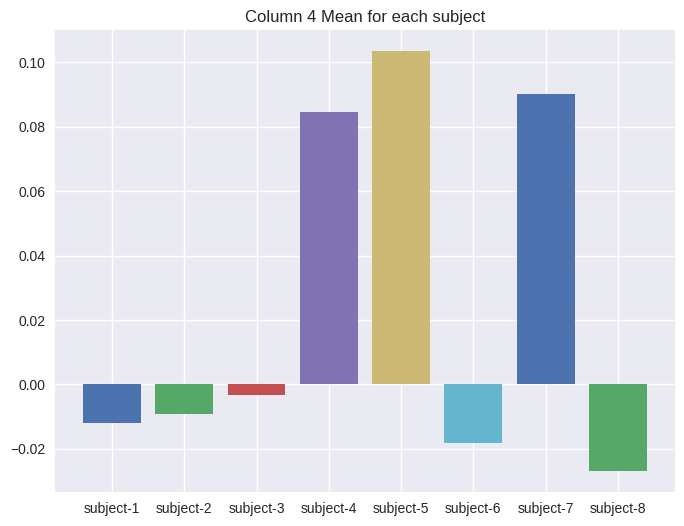

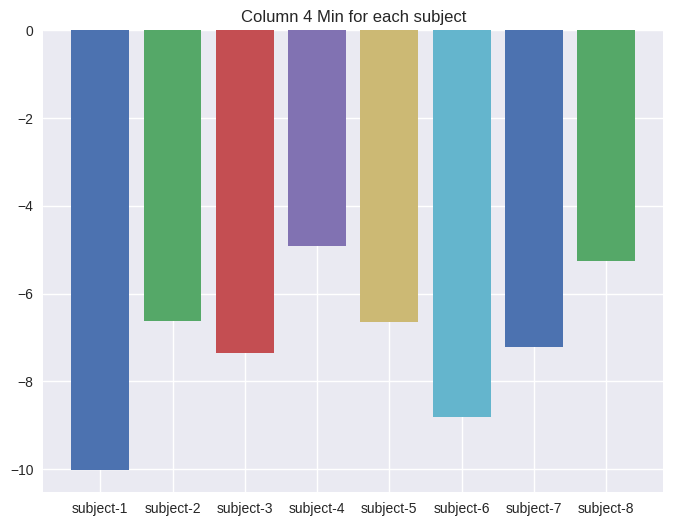

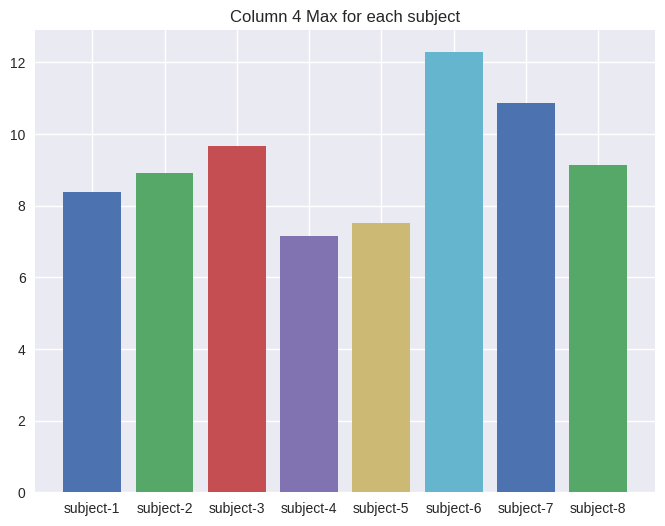

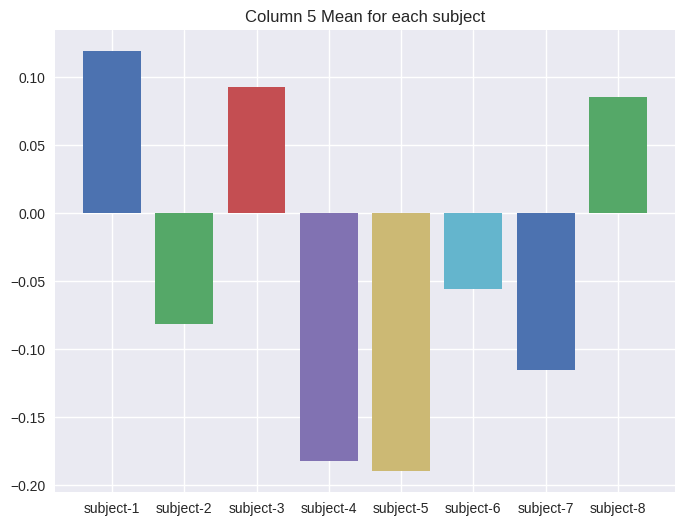

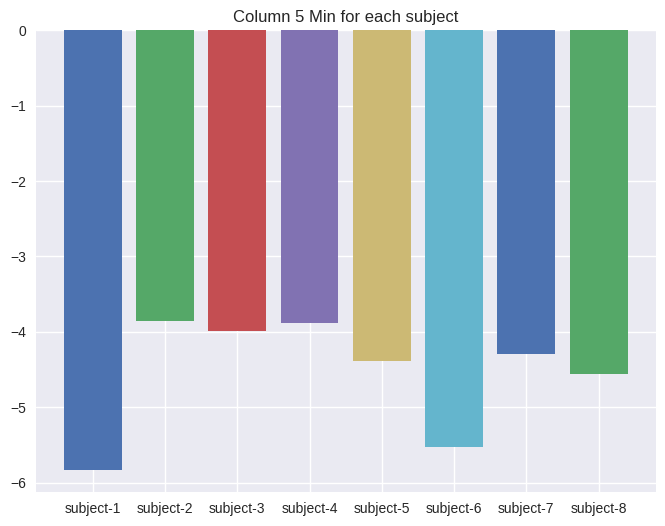

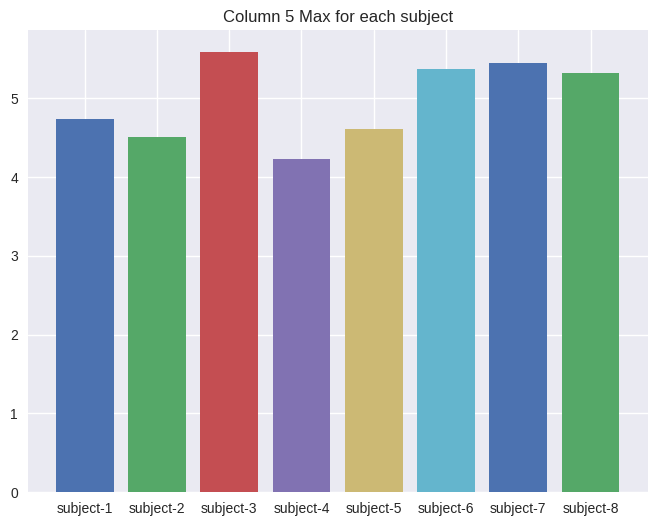

In [20]:
for key, value in actual_stats.items():

  plt.style.use('seaborn')
  plt.figure(figsize=(8,6),dpi=100)
  plt.title(f"Column {key} Mean for each subject")
  text = [f'subject-{i}' for i in range(1,9)]
  stats = value['mean']
  for bar in range(8):
      plt.bar(text[bar],stats[bar])

  plt.style.use('seaborn')
  plt.figure(figsize=(8,6),dpi=100)
  plt.title(f"Column {key} Min for each subject")
  stats = value['min']
  for bar in range(8):
      plt.bar(text[bar],stats[bar])


  plt.style.use('seaborn')
  plt.figure(figsize=(8,6),dpi=100)
  plt.title(f"Column {key} Max for each subject")
  stats = value['max']
  for bar in range(8):
      plt.bar(text[bar],stats[bar])

# Others

In [ ]:
for key, value in subject_files.items():
  local_files = value
  y_labels = []
  for i in range(0, len(local_files), 4):
          x_time, x, y_time, y = local_files[i: i + 4]
          train_df = None
        
          #X_features
          x_time_df = pd.read_csv(PATH + x_time, header=None)
          x_time_df.astype('float64')
          x_df = pd.read_csv(PATH + x, header=None)
          x_combined = pd.concat([x_time_df, x_df], axis=1, ignore_index=True)
          x_combined = x_combined.rename({0:'timestamp'}, axis='columns')
          x_combined.set_index('timestamp', inplace=True)

          #Y_labels
          y_time_df = pd.read_csv(PATH + y_time , header=None)
          y_time_df.astype('float64')
          y_df = pd.read_csv(PATH + y, header=None)
          y_combined = pd.concat([y_time_df, y_df], axis=1, ignore_index=True)
          y_combined = y_combined.rename({0:'timestamp'}, axis='columns')
          y_combined.set_index('timestamp', inplace=True)
          train_df = pd.merge_asof(left=x_combined, right=y_combined, left_index=True, right_index = True, direction='nearest')  # Merging using the nearest values
          y_labels.extend(train_df['1_y'].values)
  print(key, len(y_labels))
  plt.style.use('seaborn')
  plt.figure(figsize=(8,6),dpi=100)
  plt.title(f"Subject {key} class distribution")
  text = ["standing / walking", "going downstairs","going upstairs", "walking on grass"]
  labels = list(dict(Counter(y_labels)).values())
  for bar in range(0,4):
      plt.bar(text[bar],labels[bar])

In [12]:
subject_files[1][:10], subject_files[2][:10] 

(['subject_001_01__x_time.csv',
  'subject_001_01__x.csv',
  'subject_001_01__y_time.csv',
  'subject_001_01__y.csv',
  'subject_001_02__x_time.csv',
  'subject_001_02__x.csv',
  'subject_001_02__y_time.csv',
  'subject_001_02__y.csv',
  'subject_001_03__x_time.csv',
  'subject_001_03__x.csv'],
 ['subject_002_01__x_time.csv',
  'subject_002_01__x.csv',
  'subject_002_01__y_time.csv',
  'subject_002_01__y.csv',
  'subject_002_02__x_time.csv',
  'subject_002_02__x.csv',
  'subject_002_02__y_time.csv',
  'subject_002_02__y.csv',
  'subject_002_03__x_time.csv',
  'subject_002_03__x.csv'])

In [16]:
subject_files = defaultdict(list)
total_files = []
for filename in os.listdir(PATH):
    total_files.append(filename)
total_files = sorted(total_files, key = lambda x: (int(x.split('_')[1]),int(x.split('_')[2]), x.split('_')[4] ))
for i in range(1,9):
  files = list(filter(lambda x: int(x.split('_')[1]) == i, total_files))
  subject_files[i].extend(files)

Checking the class distribution in each subject

In [ ]:
model = MGRU_FCN(6,4,25)
model.cuda()
# Specifying the loss function
criterion = nn.CrossEntropyLoss(weight = weight.float())

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# class Resnet(nn.Module):
#   def __init__(self):
#     super(Resnet, self).__init__()
#     self.resnet = ResNet(6,4)

#   def forward(self, x):
#     x = self.resnet(x.permute(0,2,1))
#     return x

model = LSTM_FCN(6,4,60)
model.cuda()
# Specifying the loss function
criterion = nn.CrossEntropyLoss(weight = weight.float())

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks